## Run RCM on the datasets

### Generating the data for Figure 2
Here we want to run the regulatory clutsering model on our proteomics, RNAseq and DNA methylation datasets.

In [1]:
import os
import pandas as pd
import seaborn as sns
from sciviso import Scatterplot
from scircm import SciRCM
from scivae import Vis
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import defaultdict
from sciutil import SciUtil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = '../data/'
data_dir = f'{base_dir}sircle/F2_DE_output_TvN/'
output_dir = f'{base_dir}sircle/F3_regulatory_clustering/'
fig_dir = '../figures/'
supp_dir = f'{base_dir}raw_downloads/supps/'
gene_name = 'hgnc_symbol'
save_fig = False
test_title = 'all_patients_ccRCC'

2022-11-18 09:43:04.483749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
prot_file = f'{data_dir}prot_DE_{test_title}_sircle.csv'
rna_file = f'{data_dir}rna_DE_{test_title}_sircle.csv'
meth_file = f'{data_dir}filtered_cpg_DE_{test_title}_sircle.csv'
sircle_file_name = f'RCM_{test_title}-GENES.csv'

# Set cutoffs for RCM
rna_padj_cutoff = 0.05
prot_padj_cutoff = 0.05
meth_padj_cutoff = 0.05

rna_logfc_cutoff = 1.0
prot_logfc_cutoff = 0.5
meth_diff_cutoff = 0.1

run_label = f'N_P{prot_logfc_cutoff}-R{rna_logfc_cutoff}-M{meth_diff_cutoff}'


In [3]:
prot = pd.read_csv(prot_file)
prot[[c for c in prot.columns if 'Protein' not in c]].to_csv( f'{data_dir}protein_DE_{test_title}_min_sircle.csv', index=False)
prot

,external_gene_name,ensembl_gene_id,chromosome_name,start_position,end_position,strand,entrezgene_id,external_synonym,hgnc_symbol,original_gene_id,...,Protein_Tumor_C3N.01651_CPT0088690003,Protein_Normal_C3N.01808_CPT0089480003,Protein_Tumor_C3N.01808_CPT0089460004,logFC_protein,stat_protein,pvalue_protein,padj_protein,B_protein,mean_protein,var_protein
0,IFITM2,ENSG00000185201,11,303655.0,309397.0,1.0,10581.0,1-8D,IFITM2,IFITM2,...,17.269921,16.677501,17.253800,0.306706,11.634648,7.949742e-24,2.452304e-23,42.889661,17.354868,0.054637
1,IFITM3,ENSG00000142089,11,319676.0,329475.0,-1.0,10410.0,1-8U,IFITM3,IFITM3,...,21.092480,20.601086,21.344087,0.557759,19.295161,3.876605e-46,2.952304e-45,94.210111,21.049552,0.114846
2,PRDX6,ENSG00000117592,1,173477330.0,173488815.0,1.0,9588.0,1-Cys,PRDX6,PRDX6,...,25.990450,26.254320,26.170450,-0.118575,-5.106544,8.124576e-07,1.293893e-06,4.151695,26.082648,0.027683
3,ALDH1L1,ENSG00000144908,3,126103562.0,126197994.0,-1.0,10840.0,10-fTHF,ALDH1L1,ALDH1L1,...,23.710141,26.240426,24.783373,-1.092975,-17.982122,1.998520e-42,1.258636e-41,85.663205,25.075177,0.464415
4,KNOP1,ENSG00000103550,16,19701937.0,19718235.0,-1.0,400506.0,101F10.1,KNOP1,KNOP1,...,17.993586,17.262391,18.181467,0.558766,16.078556,6.179155e-37,3.057268e-36,73.025495,17.672444,0.132129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11350,ZNF827,ENSG00000151612,4,145757627.0,145938823.0,-1.0,152485.0,NaN,ZNF827,ZNF827,...,16.181790,16.276270,16.363320,-0.097275,-2.058641,4.093426e-02,4.908739e-02,-5.994643,16.444990,0.103966
11351,ZNF865,ENSG00000261221,19,55605647.0,55617269.0,1.0,100507290.0,NaN,ZNF865,ZNF865,...,18.138080,18.500360,18.502200,-0.085725,-3.593619,4.181651e-04,5.772264e-04,-1.829807,18.412422,0.027388
11352,ZNF888,ENSG00000213793,19,52904415.0,52923470.0,-1.0,388559.0,NaN,ZNF888,ZNF888,...,14.751380,14.574110,14.761570,0.199540,3.536159,5.134208e-04,7.053712e-04,-2.022569,14.635384,0.154974
11353,ZNRD1,ENSG00000066379,NaN,NaN,NaN,NaN,30834.0,NaN,POLR1H,ZNRD1,...,18.668260,18.395860,18.408350,0.170129,7.316945,7.507170e-12,1.487937e-11,15.511137,18.481216,0.031437


In [5]:
rna = pd.read_csv(rna_file)
rna[[c for c in rna.columns if 'RNA' not in c]].to_csv( f'{data_dir}rna_DE_{test_title}_min_sircle.csv', index=False)



In [9]:
meth = pd.read_csv(meth_file)
meth[[c for c in meth.columns if 'CpG' not in c] + ['CpG_Beta_diff']].to_csv( f'{data_dir}cpg_DE_{test_title}_min_sircle.csv', index=False)


In [3]:
rcm = SciRCM(meth_file, rna_file, prot_file, 
             "logFC_rna", "padj_rna", "CpG_Beta_diff", "padj_meth", "logFC_protein", "padj_protein",
             "ensembl_gene_id", sep=',',
             rna_padj_cutoff=rna_padj_cutoff, 
             prot_padj_cutoff=prot_padj_cutoff, 
             meth_padj_cutoff=meth_padj_cutoff,
             rna_logfc_cutoff=rna_logfc_cutoff, 
             prot_logfc_cutoff=prot_logfc_cutoff, 
             meth_diff_cutoff=meth_diff_cutoff, 
             output_dir=data_dir,
             non_coding_genes=['None'],
             output_filename=sircle_file_name,
             bg_type = '(P&M)|(P&R)|(M&R)'
         )
rcm.run()
df = rcm.get_df()

### Figure 1.B

Plot the overlap for significant genes

11355


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


33988
--------------------------------------------------------------------------------
Number of sig. proteins 	9476	Number with logFC > 0.5:	1040	0.10975094976783453	%	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Number of sig. CpGs 	21377	Number with m.diff > 0.1:	12212	0.571268185432942	%	0.06503701336741759	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 Number of sig. RNA 	27599	Number with logFC > 1.0:	10256	0.3716076669444545	%	 
--------------------------------------------------------------------------------


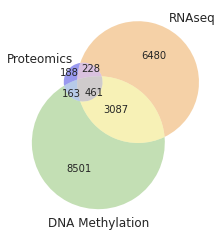

In [4]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from matplotlib_venn import venn3
from sciutil import SciUtil

save = False
u = SciUtil()
gene_id = "ensembl_gene_id"
sns.set_style('white')
font = {'family': 'normal', 'size': 9}
matplotlib.rc('font', **font)
rcParams['figure.figsize'] = (2, 2)

p_df = pd.read_csv(prot_file)
print(len(p_df))
r_df = pd.read_csv(rna_file)
m_df = pd.read_csv(meth_file)
print(len(r_df))
# Filter the genes by the overlap from our RCM
p_df = p_df[p_df['padj_protein'].values < prot_padj_cutoff]
prot_genes = p_df[p_df['logFC_protein']> prot_logfc_cutoff][gene_id].values
# Print out numbers 
u.dp(['Number of sig. proteins ', len(p_df), f'Number with logFC > {prot_logfc_cutoff}:', len(prot_genes), len(prot_genes)/len(p_df), '%'])

m_df = m_df[m_df['padj_meth'].values < meth_padj_cutoff]
meth_genes = m_df[abs(m_df['CpG_Beta_diff']) > 0.1][gene_id].values
# Print out numbers 
u.dp(['Number of sig. CpGs ', len(m_df), f'Number with m.diff > {0.1}:', len(meth_genes), len(meth_genes)/len(m_df), '%', len(meth_genes)/187770]) # Divide by all CpGs

r_df = r_df[r_df['padj_rna'].values < rna_padj_cutoff]
rna_genes = r_df[abs(r_df['logFC_rna']) > rna_logfc_cutoff][gene_id].values
# Print out numbers 
u.dp(['Number of sig. RNA ', len(r_df), f'Number with logFC > {rna_logfc_cutoff}:', len(rna_genes), len(rna_genes)/len(r_df), '%'])

venn3([set(prot_genes), set(rna_genes), set(meth_genes)], set_labels=['Proteomics', 'RNAseq',
                                                                      'DNA Methylation'],
      set_colors=('#0101d7', '#e68e25', '#6aaf44'),)
plt.rcParams['svg.fonttype'] = 'none'
if save:
    plt.savefig(f'{fig_dir}Fig1B_Venn3_input_TvN_{meth_test_title}_{run_label}.svg')

In [5]:
print(len(set(rna_genes)&set(prot_genes)), len(set(rna_genes)&set(prot_genes))/len(p_df))

689 0.07271000422119038


In [6]:
## Check how many occur in "Direct" vs "Indirect flows"
direct = ["MDS",  "MDE", "TMDE", "TMDS", "TPDE", "TPDS"]
total_direct = 0
for r in direct:
    genes = df[df['Regulation_Grouping_2'] == r]
    total_direct += len(genes)
    
indirect = ["MDS_TMDE", "MDE_TMDS", "TPDE_TMDS", "TPDS_TMDE"]
total_indirect = 0
for r in indirect:
    genes = df[df['Regulation_Grouping_2'] == r]
    total_indirect += len(genes)
print(total_direct/(total_direct + total_indirect), total_indirect/(total_direct + total_indirect))

0.3658827031854719 0.6341172968145281


## Consolidate IDs

Since each of our datasets may have different identifiers that we want to use for downstream analyeses (such as GSEA or ORA) we want to make sure that the columns are merged together (so we don't get missing idenifiers).

In [7]:
reg_label = 'Regulation_Grouping_2'
# We want to merge the entrez columns together
entrez = df[[c for c in df.columns if 'entrezgene_id' in c]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
hgnc = df[[c for c in df.columns if 'hgnc_symbol' in c]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
external = df[[c for c in df.columns if 'external_gene_name' in c]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
ensembl = df[[c for c in df.columns if 'ensembl_gene_id' in c]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

entrez_updated = []
hgnc_updated = []
external_updated = []
ensembl_updated = []
count_nan = 0
for c in entrez:
    c = c.split(' ')
    added = False
    for e in c:
        if e != 'None' and float(e) != 0 and str(e) != '0.0' and str(e) != '0':
            entrez_updated.append(e)
            added = True
            break
    if not added:
        count_nan += 1
        entrez_updated.append(None)
for c in hgnc:
    c = c.split(' ')
    added = False
    for e in c:
        if not isinstance(e, float):
            hgnc_updated.append(e)
            added = True
            break
    if not added:
        hgnc_updated.append(None)
for c in external:
    c = c.split(' ')
    added = False
    for e in c:
        if not isinstance(e, float):
            external_updated.append(e)
            added = True
            break
    if not added:
        external_updated.append(None)
for c in ensembl:
    c = c.split(' ')
    added = False
    for e in c:
        if not isinstance(e, float):
            ensembl_updated.append(e)
            added = True
            break
    if not added:
        ensembl_updated.append(None)

In [21]:
df['entrezgene_id'] = entrez_updated
## Update the RCM file
df['external_gene_name'] = external_updated
df['hgnc_symbol'] = hgnc_updated
df['ensembl_gene_id'] = ensembl_updated
print(df[reg_label].value_counts())
gene_to_ens = dict(zip(df['external_gene_name'].values, df['ensembl_gene_id'].values))
ens_to_gene = dict(zip(df['ensembl_gene_id'].values, df['external_gene_name'].values))
# Keep the DF that had regulatory labels assigned
df_og = df[df[reg_label] != 'None']
# Save the updated DF to a csv
cols = [c for c in df.columns if 'logFC' in c or 'padj' in c or 'entrezgene_id' == c or 'external_gene_name' == c or 'hgnc_symbol' == c or 'CpG_Beta_diff' in c or 'ensembl_gene_id' == c]
cols += [rcm.reg_grp_1_lbl, rcm.reg_grp_2_lbl, rcm.reg_grp_3_lbl]
df[cols].to_csv(f'{output_dir}RCM_{test_title}_{run_label}-GENES.csv', index=False)

None         10303
TPDS_TMDE     1420
MDE_TMDS      1308
TPDE_TMDS     1069
TMDS           803
TPDS           539
MDS_TMDE       463
MDE            415
TMDE           313
TPDE           257
MDS            131
Name: Regulation_Grouping_2, dtype: int64


In [10]:
vc = df_og['Regulation_Grouping_2'].value_counts()
total = vc.sum()
labels = vc.index
for i, c in enumerate(vc):
    print(labels[i], c, 100* (c/total))

TPDS_TMDE 1420 21.137243227150936
MDE_TMDS 1308 19.470080381065795
TPDE_TMDS 1069 15.91247395058053
TMDS 803 11.952962191128313
TPDS 539 8.023221196784757
MDS_TMDE 463 6.891932122655551
MDE 415 6.1774337600476334
TMDE 313 4.659124739505805
TPDE 257 3.8255433164632335
MDS 131 1.9499851146174456


In [11]:
# vc.TPDS_TMDE 1420 21.137243227150936
# MDE_TMDS 1308 19.470080381065795
# TPDE_TMDS 1069 15.91247395058053
# TMDS 803 11.952962191128313
# TPDS 539 8.023221196784757
# MDS_TMDE 463 6.891932122655551
# MDE 415 6.1774337600476334
# TMDE 313 4.659124739505805
# TPDE 257 3.8255433164632335
# MDS 131 1.9499851146174456


In [12]:
# TPDS_TMDE     1420
# MDE_TMDS      1308
# TPDE_TMDS     1069
# TMDS           803
# TPDS           539
# MDS_TMDE       463
# MDE            415
# TMDE           313
# TPDE           257
# MDS            131

In [13]:
print(df[rcm.reg_grp_1_lbl].value_counts())

None                           10303
MDE_TMDS_M-neg_R-pos_P--        1308
TPDE_TMDS_M--_R-pos_P--          812
TPDS_TMDE_M-neg_R-neg_P--        710
TPDS_TMDE_M--_R-neg_P--          701
TMDS_M--_R--_P-neg               468
MDS_TMDE_M-pos_R-neg_P--         463
MDE_M-neg_R-pos_P-pos            415
TPDS_M--_R-neg_P-neg             337
TPDE_TMDS_M-pos_R-pos_P--        256
TPDS_TMDS_M-neg_R--_P-neg        256
TPDE_M--_R-pos_P-pos             222
TPDS_M-neg_R-neg_P-neg           202
TMDE_M--_R--_P-pos               142
TPDS_TMDE_M-neg_R--_P-pos        136
MDS_M-pos_R-neg_P-neg            131
TPDE_TMDS_M-pos_R--_P-neg         53
TPDE_M-pos_R-pos_P-pos            35
TPDE_TMDE_M-pos_R--_P-pos         27
MDE_TMDS_M-neg_R-pos_P-neg        16
TPDE_TMDS_M--_R-pos_P-neg         10
TPDS_TMDE_M-neg_R-neg_P-pos        9
TPDS_TMDE_M--_R-neg_P-pos          6
MDS_TMDE_M-pos_R-neg_P-pos         2
TPDE_TMDS_M-pos_R-pos_P-neg        1
Name: Regulation_Grouping_1, dtype: int64


In [14]:
print(df[rcm.reg_grp_2_lbl].value_counts())

None         10303
TPDS_TMDE     1420
MDE_TMDS      1308
TPDE_TMDS     1069
TMDS           803
TPDS           539
MDS_TMDE       463
MDE            415
TMDE           313
TPDE           257
MDS            131
Name: Regulation_Grouping_2, dtype: int64


In [15]:
print(df[rcm.reg_grp_3_lbl].value_counts())

None    10303
TMDS     3180
TMDE     2196
TPDS      539
MDE       415
TPDE      257
MDS       131
Name: Regulation_Grouping_3, dtype: int64


## Show how the patients cluster via RCM

Here we show a PCA of the patients and colour by the regulatory clusters.

We do this to show that it's not any specific information.

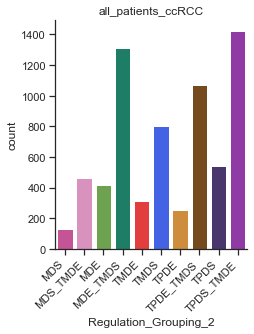

In [16]:
import itertools
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 3,2
sns.set(rc={'figure.figsize':(3,2)}, style='ticks')
#
colour_map = { 'MDS': '#d8419b', 'MDS_TMDE': '#e585c0', 'MDS_ncRNA': '#d880b4',
               'MDE': '#6aaf44', 'MDE_TMDS': '#0e8e6d', 'MDE_ncRNA': '#9edb77',
               'TMDE': '#fe2323', 'TMDS': '#2952ff',
               'TPDE': '#e68e25', 'TPDE_TMDS': '#844c0f',
                'TPDS': '#462d76', 'TPDS_TMDE': '#9b29b7'}

sns.set_palette("Greys_r")
rcm_labels = ["MDS", "MDS_TMDE", "MDE", "MDE_TMDS", "TMDE", "TMDS", "TPDE", "TPDE_TMDS",  "TPDS", "TPDS_TMDE"]
colours = [colour_map[c] for c in rcm_labels]

g = sns.catplot(data=df_og, x=reg_label, kind="count", order=rcm_labels, palette=sns.color_palette(colours), 
               height=4)
plt.xticks(rotation=45, ha='right')
plt.title(f'{test_title}')
if save_fig:
    plt.savefig(f'{fig_dir}barplot_{test_title}_{run_label}TvN.svg')
plt.show()


## Plot a couple of genes as examples

In [23]:
df

,index,ensembl_gene_id,external_gene_name_r,entrezgene_id_r,hgnc_symbol_r,logFC_rna,stat_rna,pvalue_rna,padj_rna,lfcSE_rna,...,stat_protein,pvalue_protein,padj_protein,B_protein,mean_protein,var_protein,Number of significant datasets,Regulation_Grouping_1,Regulation_Grouping_2,Regulation_Grouping_3
0,0,ENSG00000000003,TSPAN6,7105.0,TSPAN6,-0.773760,-10.546627,5.265341e-26,2.069123e-25,0.073366,...,-6.461321,8.980376e-10,1.633907e-09,10.801309,21.138595,0.147012,3.0,None,None,None
1,1,ENSG00000000005,TNMD,64102.0,TNMD,-1.224928,-6.091198,1.120691e-09,2.276478e-09,0.201098,...,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,1.0,TPDS_TMDE_M-neg_R-neg_P--,TPDS_TMDE,TMDE
2,2,ENSG00000000419,DPM1,8813.0,DPM1,0.262502,6.202639,5.552402e-10,1.144629e-09,0.042321,...,-8.941360,3.951746e-16,9.204529e-16,25.261467,22.484255,0.035362,3.0,None,None,None
3,3,ENSG00000000457,SCYL3,57147.0,SCYL3,-0.059245,-2.123760,3.369025e-02,4.181967e-02,0.027896,...,3.658355,3.311039e-04,4.600691e-04,-1.609949,18.864137,0.049438,1.0,None,None,None
4,4,ENSG00000000460,C1orf112,55732.0,C1orf112,0.654210,18.464471,3.989089e-76,6.356361e-75,0.035431,...,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,1.0,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17016,38291,ENSG00000284571,0,0.0,0,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,...,4.259760,3.255540e-05,4.782851e-05,0.593930,23.611400,0.018338,1.0,None,None,None
17017,38303,ENSG00000285152,0,0.0,0,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,...,3.197978,1.628479e-03,2.166536e-03,-3.099788,21.583704,0.009328,1.0,None,None,None
17018,38315,ENSG00000288293,0,0.0,0,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,...,2.129974,3.449705e-02,4.164955e-02,-5.848041,21.514648,0.008900,1.0,None,None,None
17019,38327,ENSG00000288705,0,0.0,0,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,...,3.925908,1.218964e-04,1.732983e-04,-0.664554,16.243394,0.047244,1.0,None,None,None


In [24]:
# Convert the data into three data frames for each of the data types
df = rcm.df
cpg_cols = [c for c in df.columns if 'CpG' in c and ('Normal' in c or 'Tumor' in c)]
rna_cols = [c for c in df.columns if 'RNA' in c and ('Normal' in c or 'Tumor' in c)]
protein_cols = [c for c in df.columns if 'Protein' in c and ('Normal' in c or 'Tumor' in c)]
box_df = pd.DataFrame()
values = []
sample_types = []
data_types = []
gene_names = []
for i, g in enumerate(df['external_gene_name'].values):
    for c in cpg_cols:
        gene_names.append(g)
        sample_types.append(c.split('_')[1])
        values.append(df[c][i])
        data_types.append('CpG')
    for c in rna_cols:
        gene_names.append(g)
        sample_types.append(c.split('_')[1])
        values.append(df[c][i])
        data_types.append('RNA')
    for c in protein_cols:
        gene_names.append(g)
        sample_types.append(c.split('_')[1])
        values.append(df[c][i])
        data_types.append('Protein')

In [25]:
box_df['Data'] = data_types
box_df['SampleType'] = sample_types
box_df['values'] = values
box_df['GeneId'] = gene_names
box_df

,Data,SampleType,values,GeneId
0,CpG,Tumor,0.517645,TSPAN6
1,CpG,Tumor,0.428932,TSPAN6
2,CpG,Tumor,0.444140,TSPAN6
3,CpG,Tumor,0.406130,TSPAN6
4,CpG,Tumor,0.395734,TSPAN6
...,...,...,...,...
11472149,Protein,Normal,13.500740,0
11472150,Protein,Normal,13.421920,0
11472151,Protein,Tumor,13.395050,0
11472152,Protein,Normal,13.487270,0


In [39]:
p = box_df[box_df['Data'] == 'Protein']
r = box_df[box_df['Data'] == 'RNA']
c = box_df[box_df['Data'] == 'CpG']

In [40]:
# Now we can iterate through each one and do whatever we need to do
fig_size = (6, 3)
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['svg.fonttype'] = 'none' 
import os
from sciviso import Boxplot


vis_opts = {"figsize": fig_size, "title_font_size": 12, "axis_font_size": 10, 
           'palette': ['lightgrey', 'dimgrey']}

def plot_gene_logfcs_simple(gene, cond0, cond1, x="Stage", cmap="Purples"):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    box_data_df = p
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        print(gene, len(gene_data))
        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'Protein',
                xlabel="Sample", ylabel=f"Protein {cond1}-{cond0}", config=vis_opts)
        b.plot(ax=ax[2])
    except:
        print('Protein')
        
    box_data_df = r
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        print(gene, len(gene_data))

        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'RNA',
                xlabel="Sample", ylabel=f"RNA", config=vis_opts)
        b.plot(ax=ax[1])
    except:
        print('RNA')
        
    box_data_df = c
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        print(gene, len(gene_data))

        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'CpG',
                xlabel="Sample", ylabel=f"CpG", config=vis_opts)
        b.plot(ax=ax[0])
    except:
        print('RNA')

    # ALso print the URL so that I can quickly check the ones that look good in protein atlas
    print(f'https://www.proteinatlas.org/{gene}-{gene_name}/pathology/renal+cancer/KIRC')
    fig.suptitle(f'{gene_name} ({cond1}-{cond0})', fontsize=16, fontweight='bold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.8)
    if save_fig:
        plt.savefig(f'{fig_dir}boxplot_{gene_name}_{cond1}-{cond0}.svg')
    plt.show()

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 29.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


EPCAM 184
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.725e-31 U_stat=8.328e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 60.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


EPCAM 239
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.836e-33 U_stat=1.142e+04


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 37.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


EPCAM 251
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.023e-15 U_stat=3.031e+03
https://www.proteinatlas.org/EPCAM-EPCAM/pathology/renal+cancer/KIRC


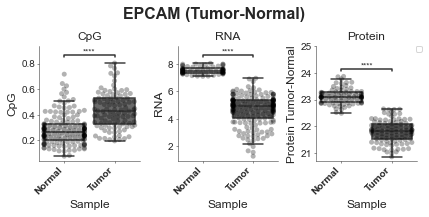

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RPL7 184
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.045e-29 U_stat=1.540e+02


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 39.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RPL7 239
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.167e-16 U_stat=1.784e+03
RPL7 251


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 95.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 93.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.550e+03
https://www.proteinatlas.org/RPL7-RPL7/pathology/renal+cancer/KIRC


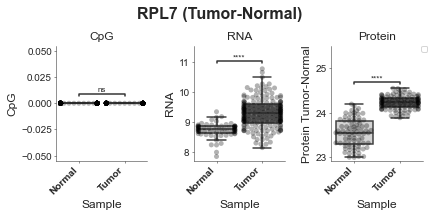

DRD2 184


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 91.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 93.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.172e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 64.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DRD2 239
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.420e-07 U_stat=8.062e+03
DRD2 251


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 92.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.095e-32 U_stat=9.070e+02
https://www.proteinatlas.org/DRD2-DRD2/pathology/renal+cancer/KIRC


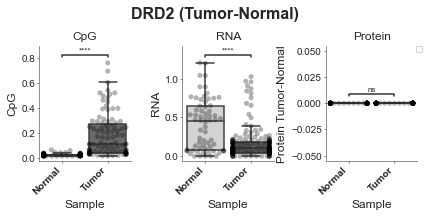

In [34]:
save_fig = True
for gene_name in ['EPCAM', 'RPL7', 'DRD2']:
    plot_gene_logfcs_simple(gene_name, 'Normal', 'Tumor',  x='SampleType')

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AURKA 184
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.805e-02 U_stat=3.323e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 40.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AURKA 239
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.858e-26 U_stat=6.220e+02


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 34.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AURKA 251
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.620e-10 U_stat=4.019e+03
https://www.proteinatlas.org/AURKA-AURKA/pathology/renal+cancer/KIRC


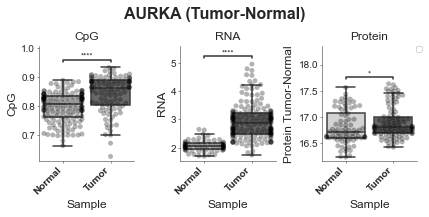

EDN1 184


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 91.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 93.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.172e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 19.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 43.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


EDN1 239
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.843e-22 U_stat=1.085e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 61.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


EDN1 251
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.230e-24 U_stat=1.859e+03
https://www.proteinatlas.org/EDN1-EDN1/pathology/renal+cancer/KIRC


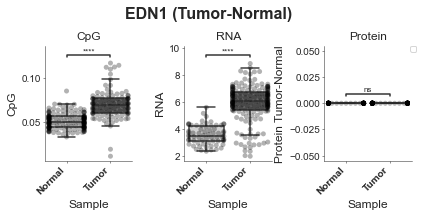

NEK2 184


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 91.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 93.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.172e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 45.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NEK2 239
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.261e-31 U_stat=1.170e+02


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 66.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NEK2 251
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.644e-29 U_stat=1.386e+04
https://www.proteinatlas.org/NEK2-NEK2/pathology/renal+cancer/KIRC


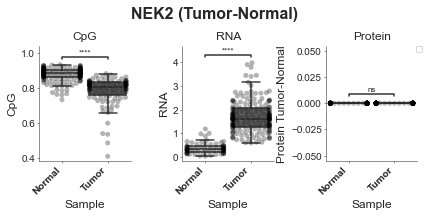

CDC25C 184


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 91.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 93.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.172e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 53.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 43.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CDC25C 239
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.419e-30 U_stat=2.160e+02


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 55.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CDC25C 251
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.274e-09 U_stat=1.097e+04
https://www.proteinatlas.org/CDC25C-CDC25C/pathology/renal+cancer/KIRC


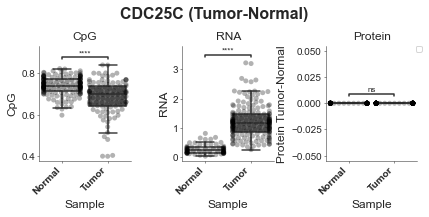

In [41]:
save_fig = True
for gene_name in ['AURKA', 'EDN1', 'NEK2', 'CDC25C']:
    plot_gene_logfcs_simple(gene_name, 'Normal', 'Tumor',  x='SampleType')

KCNA1 184


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 91.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 93.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.172e+03
KCNA1 239


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 59.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 86.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.119e-20 U_stat=9.991e+03
KCNA1 251


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 88.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.312e-40 U_stat=6.000e+01
https://www.proteinatlas.org/KCNA1-KCNA1/pathology/renal+cancer/KIRC


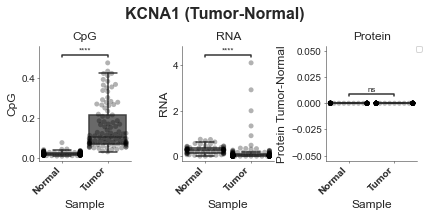

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 37.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 29.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DDR2 184
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.206e-12 U_stat=1.623e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 48.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 52.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DDR2 239
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.187e-03 U_stat=7.078e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 66.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DDR2 251
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.384e-30 U_stat=1.402e+04
https://www.proteinatlas.org/DDR2-DDR2/pathology/renal+cancer/KIRC


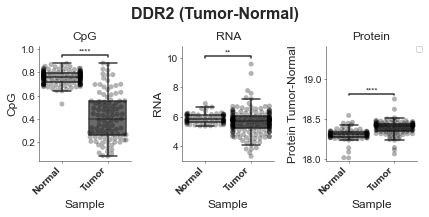

GRINK2 0
Protein
GRINK2 0
RNA
GRINK2 0
RNA
https://www.proteinatlas.org/GRINK2-GRINK2/pathology/renal+cancer/KIRC


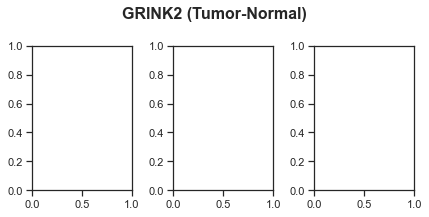

NTSR1 184


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 91.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 93.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.172e+03


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NTSR1 239
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.774e-18 U_stat=9.860e+03
NTSR1 251


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 85.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Normal v.s. Tumor: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.171e-31 U_stat=9.570e+02
https://www.proteinatlas.org/NTSR1-NTSR1/pathology/renal+cancer/KIRC


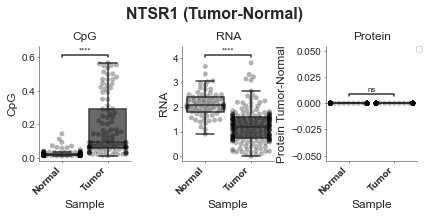

In [42]:
save_fig = True
for gene_name in ['KCNA1', 'DDR2', 'GRINK2', 'NTSR1']:
    plot_gene_logfcs_simple(gene_name, 'Normal', 'Tumor', x='SampleType')